In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắng index với Price
df = pd.read_csv('/content/drive/MyDrive/StockData/HPG.csv')
df=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 26ms/step - loss: 0.0664 - val_loss: 0.0061
Epoch 2/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/100
13/13 [==============================] - 0s 13ms/step - loss: 6.0286e-04 - val_loss: 0.0019
Epoch 4/100
13/13 [==============================] - 0s 13ms/step - loss: 5.2131e-04 - val_loss: 0.0014
Epoch 5/100
13/13 [==============================] - 0s 14ms/step - loss: 5.0160e-04 - val_loss: 0.0017
Epoch 6/100
13/13 [==============================] - 0s 14ms/step - loss: 4.5605e-04 - val_loss: 0.0018
Epoch 7/100
13/13 [==============================] - 0s 14ms/step - loss: 4.3980e-04 - val_loss: 0.0021
Epoch 8/100
13/13 [==============================] - 0s 14ms/step - loss: 4.2605e-04 - val_loss: 0.0014
Epoch 9/100
13/13 [==============================] - 0s 13ms/step - loss: 4.1789e-04 - val_loss: 0.0013
Epoch 10/100
13/13 [==============================] - 0s 15ms/step - los

In [16]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 23ms/step


In [17]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [18]:
train_size1 = int(0.7 * len(df))
test_size1 = int(0.2 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [19]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 1708.4450104992395
Testing RMSE: 9769.909857592196
Validation MAPE: 6.712444871967047
Testing MAPE: 29.23181905489256
Validation MAE: 1315.3412202380953
Testing MAE: 7952.871006826763


In [20]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=66
i=0
while(i<30):

    if(len(temp_input)>66):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.3863988]
67
1 day input [0.361479   0.35462669 0.35599715 0.37518364 0.37792457 0.37792457
 0.3806655  0.37518364 0.35325622 0.3806655  0.36833132 0.35599715
 0.34503344 0.35736761 0.35325622 0.35599715 0.35599715 0.36696086
 0.36421993 0.36696086 0.36696086 0.36696086 0.37244271 0.37518364
 0.38614735 0.38614735 0.37792457 0.36421993 0.36696086 0.3655904
 0.35736761 0.36284947 0.36833132 0.37107225 0.36696086 0.36696086
 0.36421993 0.36284947 0.37381318 0.39985199 0.39162921 0.39025874
 0.3806655  0.38477689 0.38888828 0.39437013 0.39162921 0.39299967
 0.40944524 0.40259292 0.39985199 0.39437013 0.39848153 0.39437013
 0.39711106 0.39162921 0.3806655  0.37792457 0.37518364 0.38477689
 0.38203596 0.37792457 0.38340642 0.38888828 0.39025874 0.38639879]
1 day output [[0.3883605]]
2 day input [0.35462669 0.35599715 0.37518364 0.37792457 0.37792457 0.3806655
 0.37518364 0.35325622 0.3806655  0.36833132 0.35599715 0.34503344
 0.35736761 0.35325622 0.35599715 0.35599715 0.36696086 0.364219

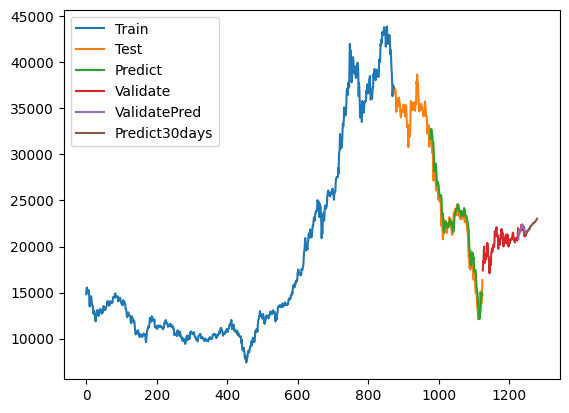

In [21]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()